In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython.display import clear_output

import copy
from collections import deque

import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from tqdm import tqdm
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10, 8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

# Часть первая, с блекджеком и стратегиями

In [2]:
def compute_pi_by_simple_strategy(player_current_sum: int, 
                                  dealers_card: int, 
                                  is_holding_a_usable_ace: bool) -> int:
    """
    returns 1 if `hit`
    return 0 if `stand`
    """
    if player_current_sum in (19, 20, 21):
        return 0
    else:
        return 1

In [22]:
def compute_mc_mean_reward_distribution(num_samples=1000, num_experiments=1000):
    """Compute reward distribution by Monte-Carlo methods.
       Returns two lists: rewards, amount of steps
    """
    mean_total_rewards, mean_total_steps = [], []
    env = gym.make("Blackjack-v1")
    env._max_episode_steps = 10000
    for sample in tqdm(range(num_samples)):
        num_steps, total_reward = [], []
        for _ in range(num_experiments):
            obs = env.reset()
            for step in range(1000):
                obs, reward, done, info = env.step(compute_pi_by_simple_strategy(*obs))
                if done:
                    num_steps.append(step + 1)
                    total_reward.append(reward)
                    break
        mean_total_rewards.append(np.mean(total_reward))
        mean_total_steps.append(np.mean(num_steps))
    env.close()
    return mean_total_rewards, mean_total_steps

In [23]:
NUM_SAMPLES = 1000
NUM_EXPERIMENTS = 1000

In [24]:
mean_mc_rewards, mean_mc_steps = compute_mc_mean_reward_distribution(num_samples=NUM_SAMPLES, num_experiments=NUM_EXPERIMENTS)

100%|██████████| 1000/1000 [01:05<00:00, 15.28it/s]


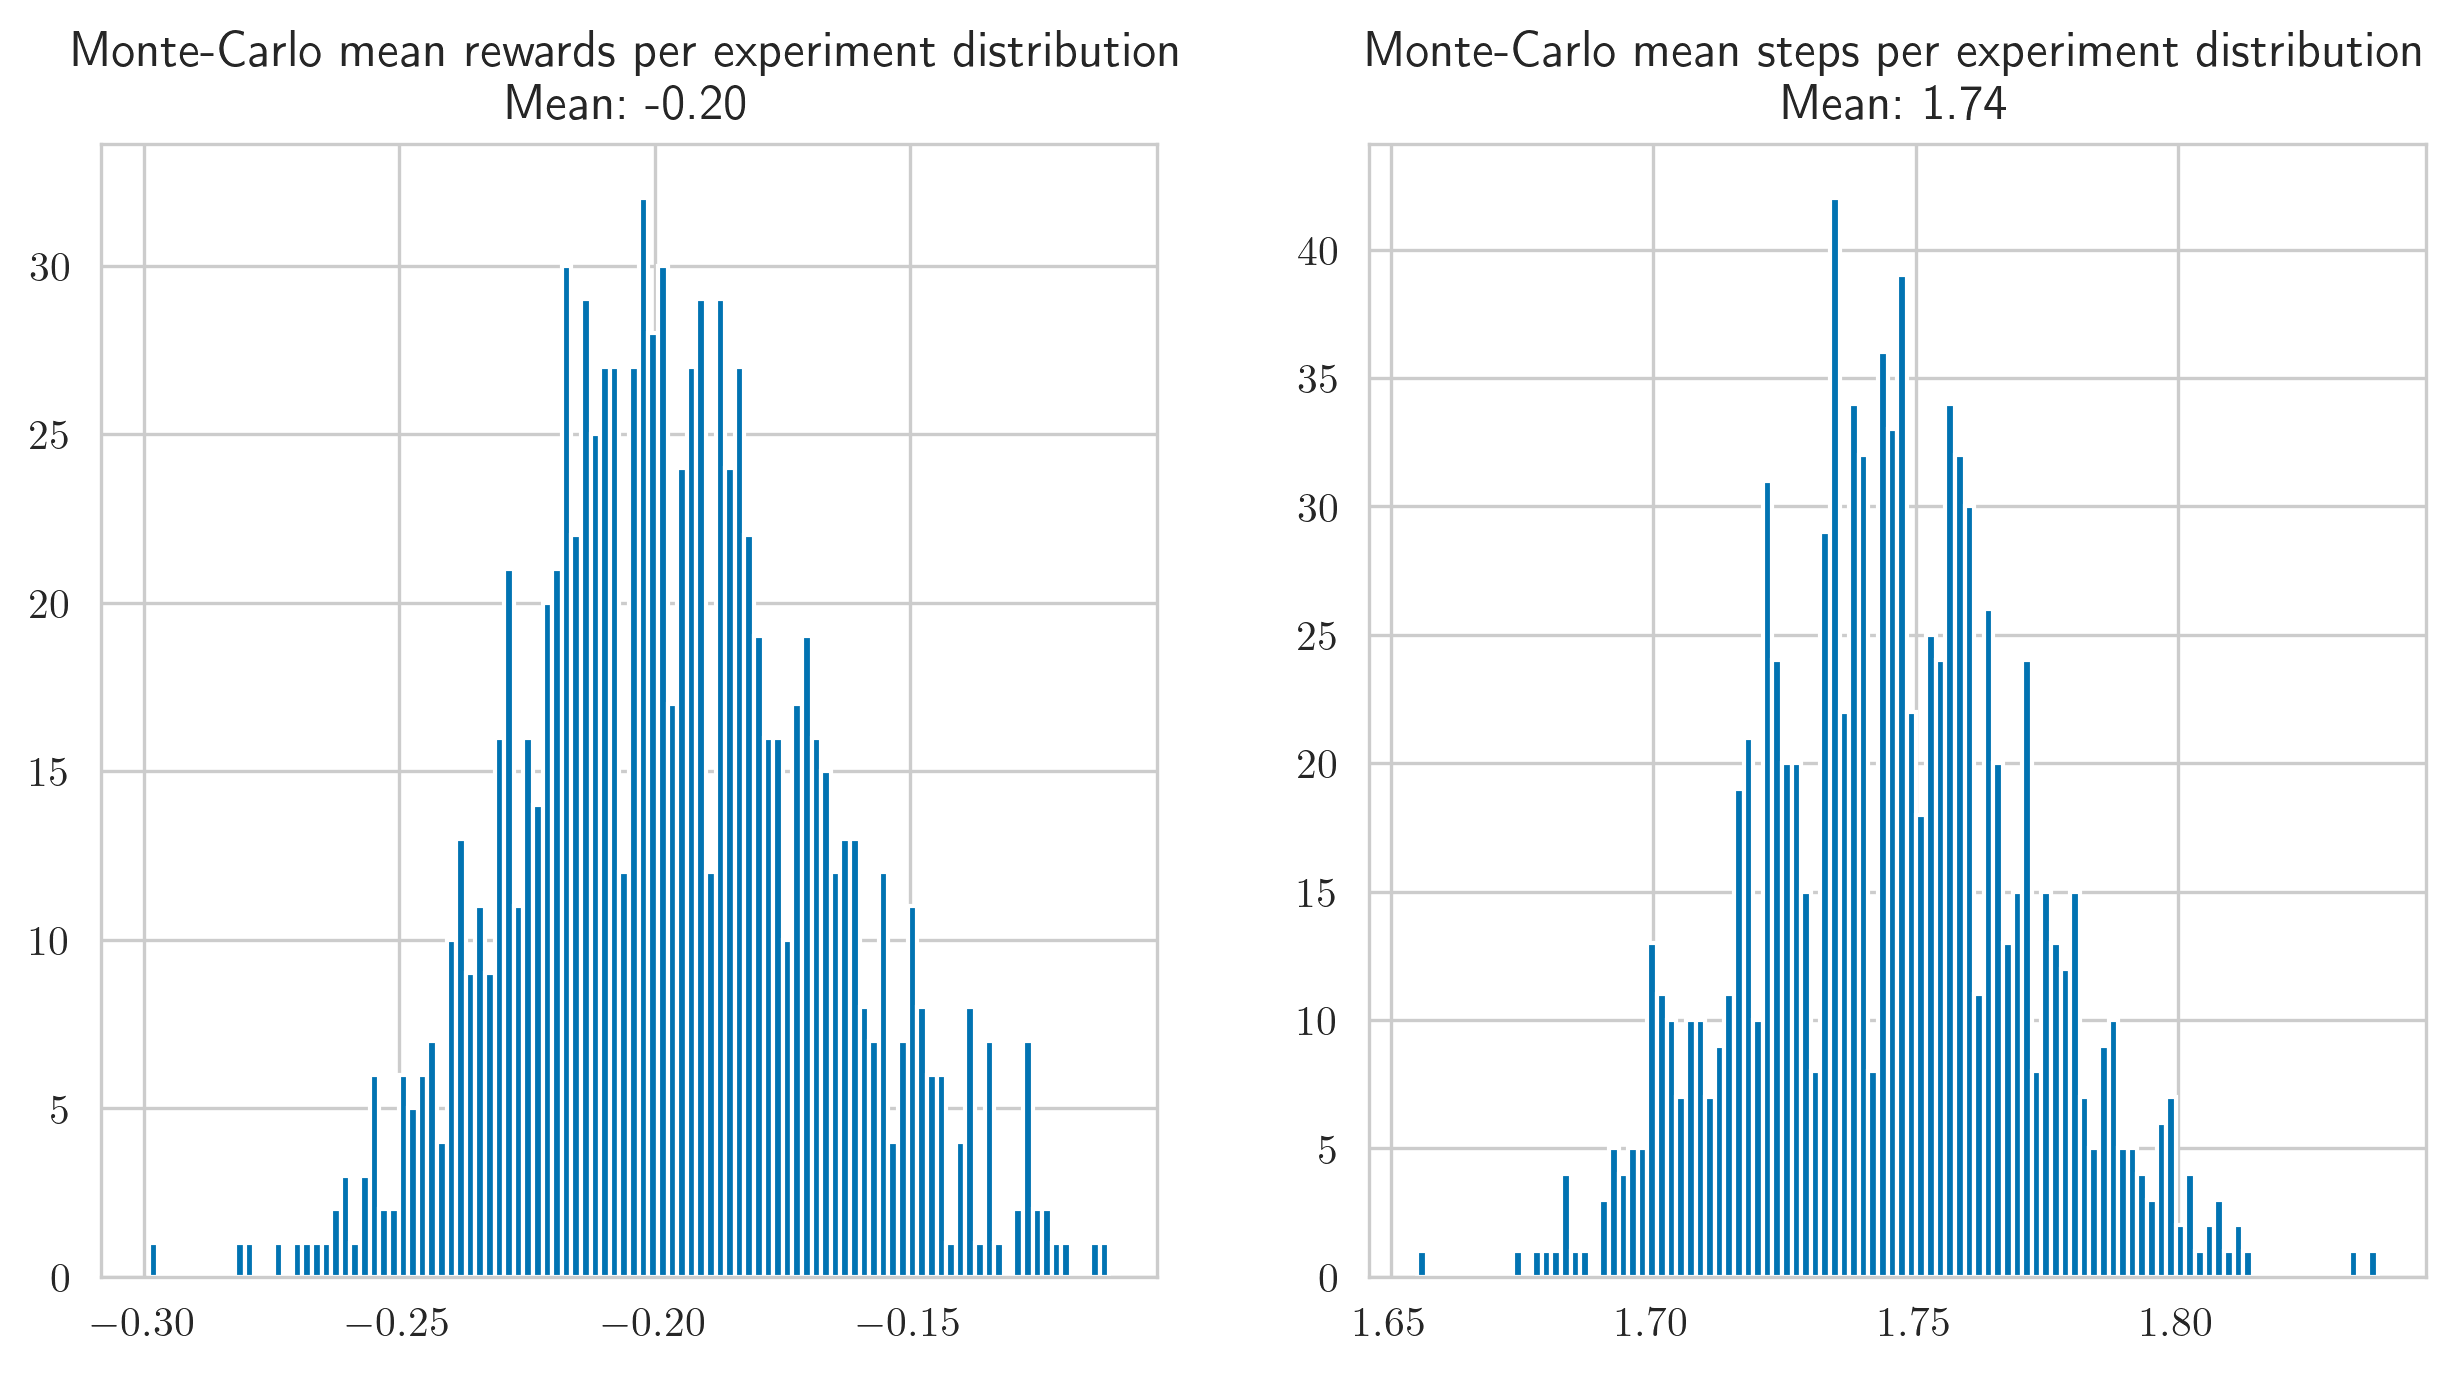

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(mean_mc_rewards, bins=100)
ax[0].set_title(f"Monte-Carlo mean rewards per experiment distribution\nMean: {np.mean(mean_mc_rewards):.2f}")
ax[1].hist(mean_mc_steps, bins=100)
ax[1].set_title(f"Monte-Carlo mean steps per experiment distribution\nMean: {np.mean(mean_mc_steps):.2f}")
plt.draw()

### Базовая стратегия не позволила обыграть казино

In [117]:
def get_random_q(env):
    state_size = env.observation_space[0].n * env.observation_space[1].n * env.observation_space[2].n
    action_size = env.action_space.n
    Q = np.random.random(size=(state_size, action_size))
    compliance = {}
    idx = 0
    for player_cur_sum in range(env.observation_space[0].n):
        for dealer_card in range(env.observation_space[1].n):
            for is_usable_ace in range(env.observation_space[2].n):
                compliance[(player_cur_sum, dealer_card, bool(is_usable_ace))] = idx
                idx += 1
    return Q, compliance

def compute_policy_by_q(Q, state):
    return np.argmax(Q[state])

def q_learning_episode(env, Q, compliance, alpha, epsilon, gamma, estimate=False):
    s = env.reset()
    a = compute_policy_by_q(Q, compliance[s]) if (np.random.rand() > epsilon or estimate) else env.action_space.sample()
    for _ in range(1000):
        s_prime, reward, done, info = env.step(a)
        a_prime = compute_policy_by_q(Q, compliance[s_prime]) if (np.random.rand() > epsilon or estimate) else env.action_space.sample()
        if not estimate:
            Q[compliance[s]][a] = Q[compliance[s]][a] + alpha * (reward + gamma * np.max(Q[compliance[s_prime]]) - Q[compliance[s]][a])
        s, a = s_prime, a_prime
        if done:
            break
    return reward

def run_qlearning(env, total_episodes=25000, alpha=0.05, epsilon=0.0, gamma=0.9, return_rewards=False, verbose=10000):
    Q, compliance = get_random_q(env)
    mean_rewards = []
    cur_mean_reward = 0
    amount_of_rewards = 0
    min_reward = 100
    for idx, _ in tqdm(enumerate(range(total_episodes))):
        q_learning_episode(env, Q, compliance, alpha, epsilon, gamma)
        # estimating strategy
        reward = q_learning_episode(env, Q, compliance, alpha, epsilon, gamma, estimate=True)
        cur_mean_reward = (cur_mean_reward * amount_of_rewards + reward) / (amount_of_rewards + 1)
        amount_of_rewards += 1
        if min_reward > cur_mean_reward:
            min_reward = cur_mean_reward
        mean_rewards.append(cur_mean_reward)
        if idx % verbose == 0:
            clear_output(True)
            fig, ax = plt.subplots(1, 1, figsize=(8, 5))
            ax.set_yticks(np.arange(min_reward, 1.1, 0.1))
            ax.set_title(f"Mean reward")
            ax.set_xlabel("Games played")
            ax.set_ylabel("Cumulative mean reward")
            ax.plot(mean_rewards, label=f"Last cumulative mean reward = {mean_rewards[-1]:.3f}")
            ax.legend()
            plt.show()
    env.close()
    if return_rewards:
        return Q, mean_rewards
    return Q

In [105]:
TOTAL_EPISODES = 250000
ALPHA = 0.1
EPSILON = 0.5
GAMMA = 0.1

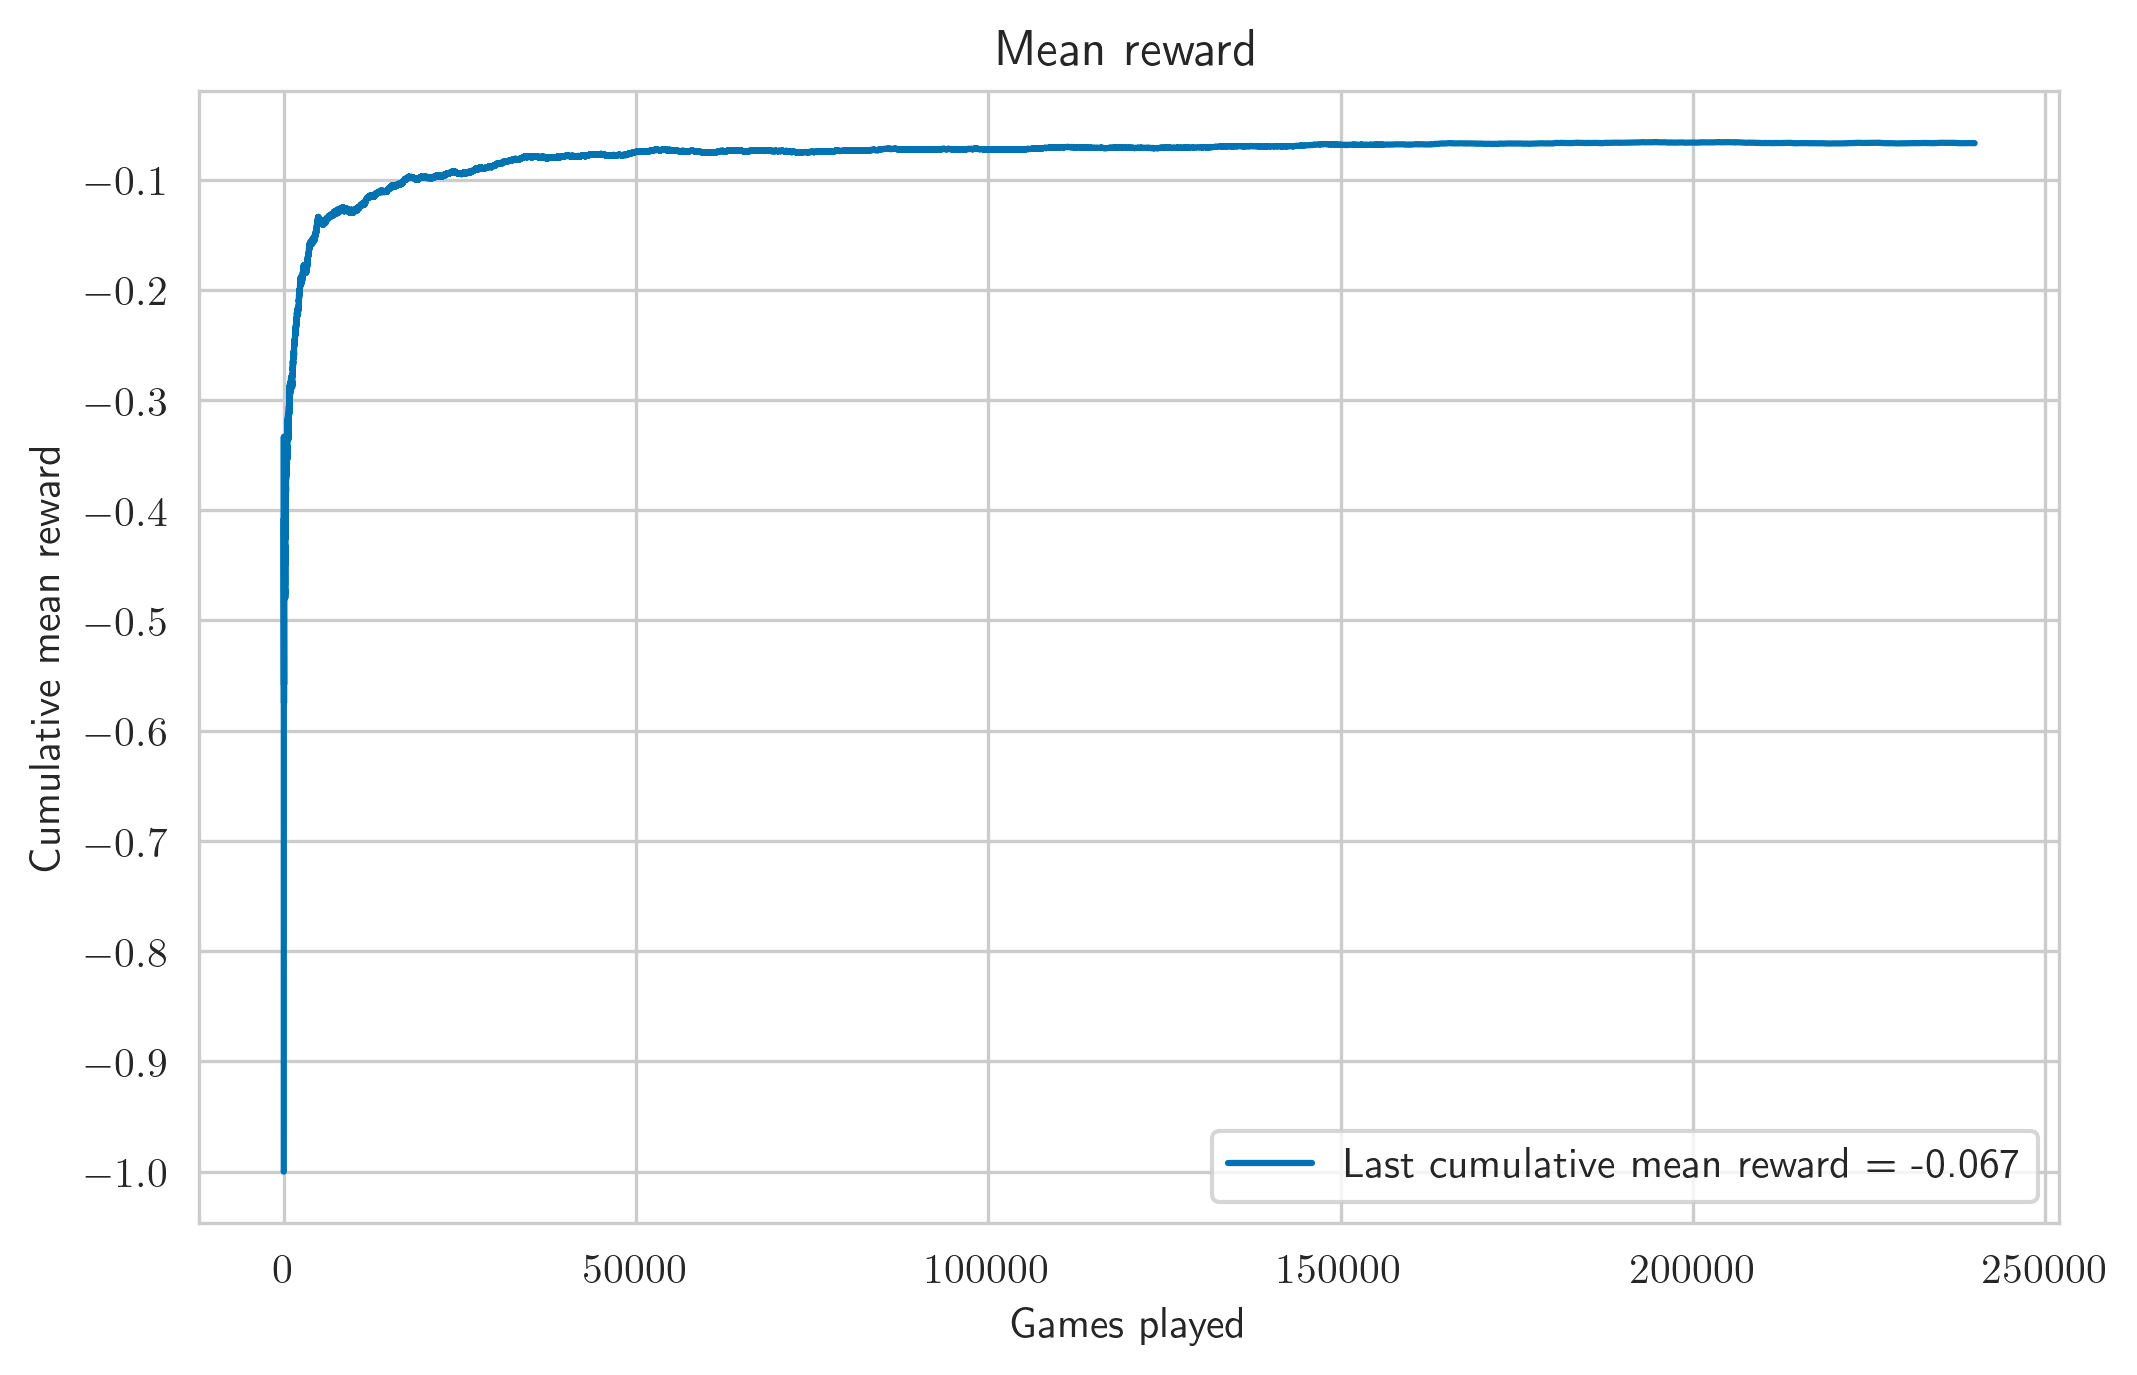

250000it [00:53, 4695.62it/s]


In [94]:
env = gym.make("Blackjack-v1")
fitted_q = run_qlearning(env, total_episodes=TOTAL_EPISODES, alpha=ALPHA, epsilon=EPSILON, gamma=GAMMA, return_rewards=False)

### Можно заметить, что с помощью Q-learning удалось значительно улучшить базовую стратегию: значение средней награды выросло с $-0.20$ до $-0.067$.

# Часть вторая, удвоенная

In [112]:
DOUBLE_TOTAL_EPISODES = 250000
DOUBLE_ALPHA = 0.1
DOUBLE_EPSILON = 0.5
DOUBLE_GAMMA = 0.1

In [115]:
from modified_blackjack import BlackjackWithDoubleEnv

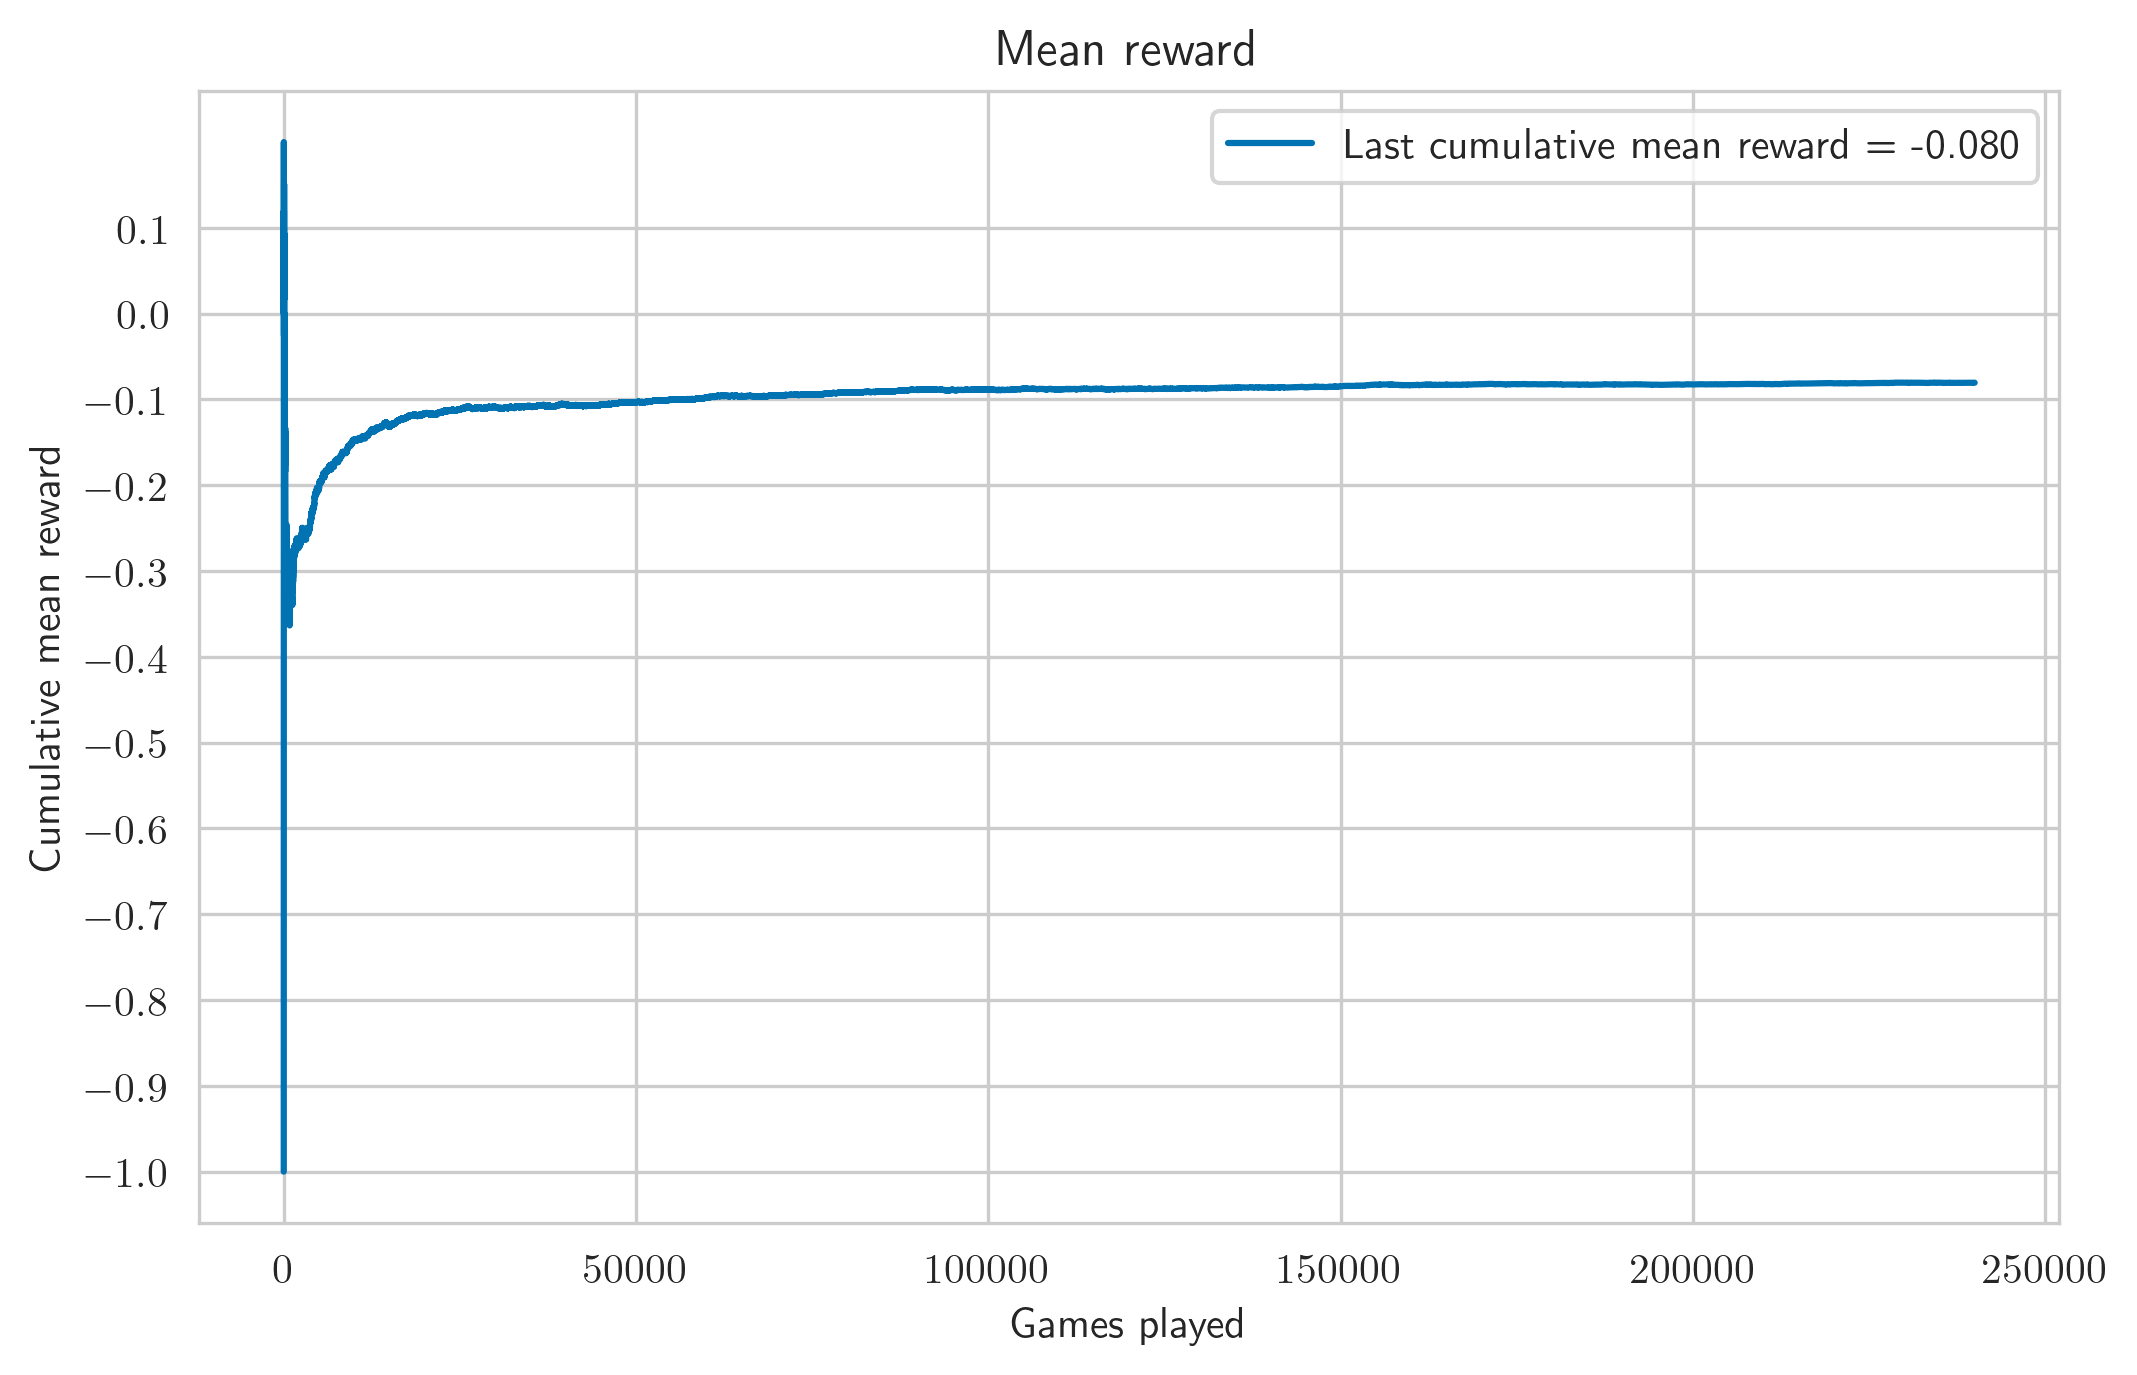

250000it [00:48, 5170.90it/s]


In [116]:
env_with_double = BlackjackWithDoubleEnv()
fitted_q_with_double = run_qlearning(env_with_double, total_episodes=DOUBLE_TOTAL_EPISODES, alpha=DOUBLE_ALPHA, epsilon=DOUBLE_EPSILON, gamma=DOUBLE_GAMMA, return_rewards=False)

### Среднее значение награды, полученное после добавления в среду `double`, тоже превысило базовую стратегию, но при этом не смогло достичь значения среды без `double`.  Это можно объяснить так: число состояний среды увеличилось, следовательно, для получения оптимальной стратегии необходимо большее число эпизодов обучения для лучшего "изучения" среды.